

   ## Modeling- multiclass classification with SMOTE
- This notebook will focus on building models that predict the poverty level of households
- Along with training the model, there are a few processing steps that I will include in a sklearn pipeline
- I will include SMOTE (oversampling the minority classes) and undersampling the majority class in this notebook

In this notebook, I will train a model to predict the poverty level of each household. The DV has 4 levels; therefore, we have a multiclass classification problem
- 1 = extreme poverty; 2 = moderate poverty; 3 = vulnerable households; 4 = non vulnerable households

- **As a rule of thumb, you should prefer the precision recall (PR) curve whenever the positive class is rare (say I want to predict whether a number is 5 (positive case) or not 5 (negative case), and only 10% of the sample are actually 5), or when you care more about the false positives (detecting a `5` when it is not a `5`, than the false negatives. I will use the ROC curve (FP does not appear!) otherwise.** 


In [1]:
'''data'''
import pandas as pd
import numpy as np
import itertools
from itertools import compress


'''common'''
from pathlib import Path
from collections import OrderedDict
import pickle


'''sklearn'''
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score, cross_val_predict, 
    train_test_split,
    cross_validate,
    RandomizedSearchCV,GridSearchCV,
    learning_curve)

from sklearn.feature_selection import SelectFromModel
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


'''imblearn'''
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


'''feature engine'''
from feature_engine.selection import DropConstantFeatures
from feature_engine.imputation import MeanMedianImputer

'''models'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier


'''metrics'''
from sklearn.metrics import (
    confusion_matrix,
    precision_score, recall_score, f1_score, 
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

'''visualization'''
import seaborn as sns
import matplotlib.pyplot as plt

'''warnings'''
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

## Config

In [2]:
# Scoring method for models
SCORING = "f1_weighted" #"f1_macro", "average_precision" 
# Random seed
RANDOM_STATE = 10

## Custom estimator

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

# This custom step saves the column names of its input dataframe as a .pkl file
class save_col_names(BaseEstimator, TransformerMixin):
    """
    Constructor

    Args:
        void

    Returns:
        void
    """

    def __init__(self, step_name:str):
        self.step_name = step_name # step_name is the name of the step prior to "save_col_names"


    def fit(self, X,
            y=None):  # need to have y as argument to make class compatible with sklearn pipeline
        """ Fit

        Args:
            X (DataFrame): a input dataframe of features to train the transformer
            y (DataFrame): a input Series of response variable to train the transformer (optional)

        Returns:
            self
        """

        return self

    def transform(self, X):
        """ Transform

        Args:
            X (DataFrame): a input dataframe of features to be transformed

        """

        # Make a copy of the input dataframe
        # so we won't overwrite the original Dataframe that was passed as argument
        X = X.copy()
        
        # Get feature names
        feature_names = X.columns.tolist
        
        # Save as pickle
        with open(Path('data','outputs',f'{self.step_name}_feature_names.pkl'), 'wb') as f:
            pickle.dump(feature_names, f)

        return X

## Import
- Load the interim data 

In [4]:
file_path = Path("data","interim", "interim.pkl")
df = pd.read_pickle(file_path)

In [5]:
df.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari_normalized_by_age-sum,escolari_normalized_by_age-std,escolari_normalized_by_age-range_,inst_normalized_by_age-max,inst_normalized_by_age-std,inst_normalized_by_age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


In [6]:
df.shape

(10307, 222)

In [7]:
# Get feature names
train_feature_names = df.columns.tolist()
# Remove Target and the Id columns
train_feature_names = [v for v in train_feature_names if v not in ["Target", "Id","idhogar"]]

In [8]:
# Create a dictionary that maps Target levels (numeric encoding) to string encoding. Use later in our plots
poverty_mapping = OrderedDict({1: 'extreme', 
                               2: 'moderate',
                               3: 'vulnerable',
                               4: 'not vulnerable'})

**Currently, the interim set contains both the train and test (hold-out) set. Separate them out.**

In [9]:
# Rows in the interim dataframe that has non-null values for the Target column are from the train dataset
X_train = df.loc[df["Target"].notnull(), train_feature_names]
y_train = df.loc[df["Target"].notnull(),"Target"]

In [10]:
# rows in the interim dataframe that has null values for the Target column are from the test (holdout) dataset
X_test  = df.loc[df["Target"].isnull(), train_feature_names]

**Note that the unit of analysis for the interim dataframe is household, as we will only be fitting a model to make predictions at the household level. There are 2973 households in X_train.**

In [11]:
X_train.shape, y_train.shape, X_test.shape

((2973, 219), (2973,), (7334, 219))

In [12]:
# Make a copy of the household_id for the households in the test set
test_ids = list(df.loc[df['Target'].isnull(), 'idhogar'])

In [13]:
len(test_ids)

7334

## Extent of missingness
- Despite imputing some of the "ignorable" cases in the previous notebook, there are still some missing values in the X_train and X_test. In this section, we will investigate and impute the remaining missing values.
- There is no missing value in y_train.

In [14]:
def extent_missinginess(df):
    return (df
         .isnull()
         .mean()
         .mul(100)
         .reset_index(name="percentage")
         .sort_values(by="percentage", ascending=False))

In [15]:
train_missing = extent_missinginess(X_train)
train_missing.head(10)

,index,percentage
213,inst_normalized_by_age-std,13.084427
210,escolari_normalized_by_age-std,13.084427
114,estadocivil2-std,13.050790
134,parentesco2-std,13.050790
128,estadocivil7-std,13.050790
99,v18q-std,13.050790
202,age-std,13.050790
190,mobilephone-std,13.050790
131,parentesco1-std,13.050790
205,inst-std,13.050790


**Data processing steps**
- At most I have 13% values missing in the train and test sets. Since the proportion of missingness is relatively small, I will impute with median.
- I will drop features that have near zero variance as they will not be useful in predicting the outcome.
- I also want to use MaxMinScaler to normalize all features as some models that we want to try might be scale variant.

## SMOTE
- Currently, the dataset has very imbalanced class. Class 4 (not vulnerable) is the majority class (0.65).
- In contrast, only 7% of the train set is Class 1 (extreme). The trained model would have trouble correctly classifying an actual Class 1 sample.
- Soultion: we will upsample the minority classes (Class 1,2,3) to have 0.25 of the sample in the majority class (around n=500 for each minority classes). I will also downsample the majority class (Class 4) so that the ratio of minority/majority is 0.5. In order words, 1000 samples for the majority class (down from 2000)

In [16]:
y_train.value_counts()

4.0    1954
2.0     442
3.0     355
1.0     222
Name: Target, dtype: int64

In [17]:
poverty_mapping

OrderedDict([(1, 'extreme'),
             (2, 'moderate'),
             (3, 'vulnerable'),
             (4, 'not vulnerable')])

Text(0, 0.5, 'Percentage')

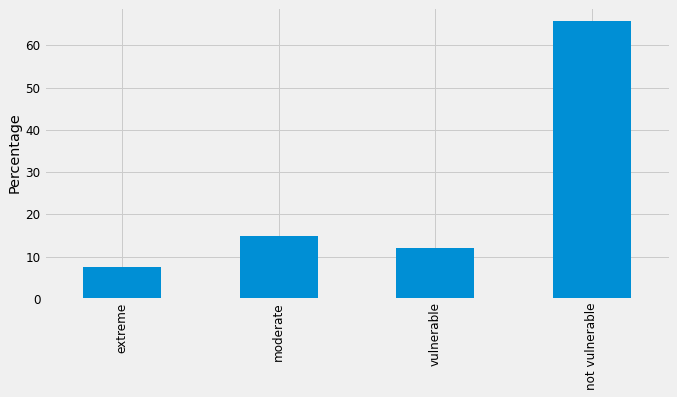

In [18]:
# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(10,5))

(y_train
 .value_counts(normalize=True)
 .mul(100)
 .sort_index()
 .plot.bar())

plt.xticks([0,1,2,3],poverty_mapping.values())
plt.ylabel("Percentage")

- By default, SMOTE will oversample all classes to have the same number of examples as the class with the most examples. So all classes would have 1954.
- Instead of using the default strategy of SMOTE to oversample all classes to the number of examples in the majority class, we could instead specify the number of examples to oversample in each class.
- Note: when using data sampling like SMOTE, it must only be applied to the training dataset, not the entire dataset. I recommend using a Pipeline to ensure that the SMOTE method is correctly used when evaluating models and making predictions with models.

In [19]:
data_pipeline = imb_pipeline(steps = [    
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === oversampling === # 
    # upsample the minority classes to have 0.25 of the majority class, so 500 for class 1-3
    ('oversampling', SMOTE(sampling_strategy={1:500, 2:500, 3:500},
                           random_state=RANDOM_STATE)),
    
    # === undersampling ==== # 
    # undersample the majority class to have 2x of minority class, so 1000 for class 4
    ('undersampling', RandomUnderSampler(sampling_strategy={4:1000},
                                         random_state=RANDOM_STATE)),  

])

In [20]:
# Since the last step is NOT a sklearn pipeline step, I can only use fit_resample() and not fit_transform()
X_processed, y_processed = data_pipeline.fit_resample(X_train, y_train)

In [21]:
y_processed.value_counts()

4.0    1000
1.0     500
2.0     500
3.0     500
Name: Target, dtype: int64

In [22]:
X_processed.shape, y_processed.shape

((2500, 219), (2500,))

I successfully downsample class 4 and upsample classes 1-3 with SMOTE

## Data pipeline with drop nzv and scaling steps
- Include imputation, drop nzv, up and down sampling, scaler steps

In [23]:
# Create pipeline
data_pipeline = imb_pipeline([
 
     # === Imputation === #
     ("missing_imputation", MeanMedianImputer(imputation_method="median")),
 
     # === drop qusai-constant variables === #
     # drop variables with any level that appears in 0.75 of observations
     ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
     # === save feature names (of the df from the drop_nzv step) ===
     ('save_feature_names', save_col_names(step_name='feature_selection')),
    
     # === oversampling === # 
     # upsample the minority classes to have 0.25 of the majority class, so 500 for class 1-3
     ('oversampling', SMOTE(sampling_strategy={1:500, 2:500, 3:500},
                            random_state = RANDOM_STATE)),
    
     # === undersampling ==== # 
     # undersample the majority class to have 2x of minority class, so 1000 for class 4
    ('undersampling', RandomUnderSampler(sampling_strategy={4:1000},
                                         random_state=RANDOM_STATE)),  
    
    # === normalization === #
    ('scaler', MinMaxScaler()), 
    
 ])

**NOTE: the output of pipeline with sklearn steps is a ndarray. It is only if the pipeline contains exclusively feature-engine steps will its output be a dataframe.**

In [24]:
# Fit and transform X_train
x_tr_processed = data_pipeline.fit_transform(X_train, y_train) 

In [25]:
x_tr_processed.shape

(2500, 91)

In [26]:
# Get saved feature names
with open(Path('data','outputs','feature_selection_feature_names.pkl'), 'rb') as f:
    list_ = pickle.load(f)
    
saved_feature_names=list_()

# Convert ndarray (output of data pipeline) to a dataframe with the saved feature names
x_tr_processed = pd.DataFrame(x_tr_processed, columns = saved_feature_names)

In [27]:
x_tr_processed.head()

,paredblolad,pisomoscer,cielorazo,energcocinar2,energcocinar3,tipovivi1,television,lugar1,area1,v2a1,...,escolari_normalized_by_age-min,escolari_normalized_by_age-max,escolari_normalized_by_age-sum,escolari_normalized_by_age-std,escolari_normalized_by_age-range_,inst_normalized_by_age-max,inst_normalized_by_age-std,inst_normalized_by_age-range_,tech-min,tech-sum
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.175,...,0.000000,0.513185,0.124008,0.422204,0.541872,0.354680,0.312582,0.358621,0.5,0.227273
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,...,0.000000,0.541176,0.073420,0.520476,0.571429,0.308571,0.314502,0.312000,0.5,0.136364
2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,...,0.142857,0.122995,0.016686,0.373198,0.000000,0.087662,0.287213,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.060,...,0.000000,0.307487,0.067937,0.258912,0.324675,0.367347,0.331315,0.371429,0.5,0.136364
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,...,0.000000,0.515406,0.069924,0.607095,0.544218,0.367347,0.458554,0.371429,0.5,0.090909


In [28]:
# Transform X_test
x_tst_processed= data_pipeline.transform(X_test)
x_tst_processed = pd.DataFrame(x_tst_processed, columns = saved_feature_names)

In [29]:
x_tst_processed.head()

,paredblolad,pisomoscer,cielorazo,energcocinar2,energcocinar3,tipovivi1,television,lugar1,area1,v2a1,...,escolari_normalized_by_age-min,escolari_normalized_by_age-max,escolari_normalized_by_age-sum,escolari_normalized_by_age-std,escolari_normalized_by_age-range_,inst_normalized_by_age-max,inst_normalized_by_age-std,inst_normalized_by_age-range_,tech-min,tech-sum
0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.000,...,0.000000,0.560976,0.147735,0.524370,0.592334,0.501742,0.482610,0.507317,0.5,0.136364
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,...,0.426150,0.366899,0.049776,0.373198,0.000000,0.305085,0.287213,0.000000,1.0,0.090909
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.175,...,0.960317,0.826797,0.112169,0.373198,0.000000,0.571429,0.287213,0.000000,1.0,0.090909
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.400,...,0.411565,0.569659,0.125357,0.253622,0.227354,0.473684,0.285591,0.231328,1.0,0.181818
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.300,...,1.000000,0.901961,0.239171,0.048292,0.043290,0.857143,0.048634,0.039394,1.0,0.181818


## Modelling

- y_train is less imbalanced after using SMOTE. But to ensure each of our folds has the same class distribution as the full train data, we still need to use StratifiedKFold, or StratifiedShuffleSplit
- Use model selection step

**Sklearn will automatically detect multiclass classification and will default to using ovr for logreg, SGD classifier
and ovo for SVC. Tree-based models and NB can handle multiclass classification without using ovr or ovo.**

In [30]:
# Model for feature selection
# I chose a tree-based classifier 
# since it handles mul|ticlass classification without using ovr or ovo (which requires training 
# more models (e.g., for each pair of classes) under the hood)
sel_clf = ExtraTreesClassifier(n_estimators=50, random_state=RANDOM_STATE)

In [31]:
# Define function to compute cv_scores for a user-specified model

def evaluate_model(X,y,clf,cv,scoring):
    
    # Create pipeline
    data_pipeline = imb_pipeline([
 
         # === Imputation === #
         ("missing_imputation", MeanMedianImputer(imputation_method="median")),
 
         # === drop qusai-constant variables === #
         # drop variables with a level that appears in 0.75 of observations
         ('drop_nzv', DropConstantFeatures(tol=0.75)),
        
        # === oversampling === # 
        # upsample the minority classes to have 0.25 of the majority class, so 500 for class 1-3
        ('oversampling', SMOTE(sampling_strategy={1:500, 2:500, 3:500},
                         random_state = RANDOM_STATE)),
    
         # === undersampling ==== # 
         # undersample the majority class to have 2x of minority class, so 1000 for class 4
        ('undersampling', RandomUnderSampler(sampling_strategy={4:1000},
                                             random_state=RANDOM_STATE)),  
 
         # === normalization === #
         ('scaler', MinMaxScaler()),
        
        # === feature selection using logreg === #
        ("feature_selection", SelectFromModel(estimator=sel_clf, threshold="1.25*median")),
        
         # === model === #
         ('model', clf)
     ])
    
    # Compute cv scores
    cv_scores = cross_val_score(estimator = data_pipeline,
                                X = X,
                                y = y,
                                scoring = scoring,
                                cv = cv,
                                n_jobs=1)
    
    return cv_scores

In [32]:
# Define the CV iterator
skf = StratifiedKFold(
    n_splits = 10,
    shuffle = True,
    random_state = RANDOM_STATE
)
skf.get_n_splits()

10

In [33]:
# Define a dict of models
models = {"dummy": DummyClassifier(random_state = RANDOM_STATE),
          "SGD" : SGDClassifier(random_state = RANDOM_STATE),
          "Random Forest": RandomForestClassifier(n_estimators= 1000, random_state = RANDOM_STATE),
          "Extra trees": ExtraTreesClassifier(random_state = RANDOM_STATE),
          "SVC" : LinearSVC(random_state = RANDOM_STATE),
          "Naive Bayes": GaussianNB(),
          "KNN": KNeighborsClassifier()
         }

In [34]:
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Train each model in the models dict, and then populate a dataframe with scores

res = {} # empty results dictionary that will contain cv_scores for each model

for k,v in models.items():
    cv_scores = evaluate_model(X = X_train,
                   y = y_train,
                   clf = v,
                   cv = skf,
                   scoring = SCORING
                  )
    # update results dictionary
    res.update({k:cv_scores})
    
    # print mean and sd cv scores of each model\
    print(f"{k}")
    print(f"mean {SCORING}: {np.round(np.mean(cv_scores),2)}")
    print(f"stdev {SCORING}: {np.round(np.std(cv_scores),2)}")
    print()

dummy
mean f1_weighted: 0.52
stdev f1_weighted: 0.0

SGD
mean f1_weighted: 0.6
stdev f1_weighted: 0.04

Random Forest
mean f1_weighted: 0.62
stdev f1_weighted: 0.03

Extra trees
mean f1_weighted: 0.61
stdev f1_weighted: 0.03

SVC
mean f1_weighted: 0.61
stdev f1_weighted: 0.02

Naive Bayes
mean f1_weighted: 0.58
stdev f1_weighted: 0.03



/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

KNN
mean f1_weighted: 0.57
stdev f1_weighted: 0.02



/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [35]:
res

{'dummy': array([0.52191397, 0.52191397, 0.52191397, 0.52473347, 0.52044839,
        0.52044839, 0.52044839, 0.52044839, 0.52044839, 0.52044839]),
 'SGD': array([0.63069145, 0.56969537, 0.65203005, 0.60441052, 0.57270321,
        0.54538941, 0.6430858 , 0.63112239, 0.58900393, 0.56773285]),
 'Random Forest': array([0.63262464, 0.62181387, 0.6574793 , 0.60188925, 0.62890314,
        0.56855882, 0.61779347, 0.67281116, 0.61499109, 0.62340561]),
 'Extra trees': array([0.63265016, 0.61742729, 0.62355147, 0.5638574 , 0.61029033,
        0.56255144, 0.62882964, 0.63034927, 0.63531091, 0.59098279]),
 'SVC': array([0.61396543, 0.60197882, 0.64889967, 0.61438771, 0.61200246,
        0.57405029, 0.62357247, 0.60788728, 0.60790872, 0.61233039]),
 'Naive Bayes': array([0.5744726 , 0.57104131, 0.62591752, 0.60848483, 0.61548229,
        0.56521157, 0.57557937, 0.60440092, 0.5567999 , 0.54859109]),
 'KNN': array([0.58592455, 0.54886834, 0.5908012 , 0.57854427, 0.56190349,
        0.52477604, 0.58565

In [36]:
# Create results dataframe
df_res = pd.DataFrame.from_dict(res)
df_res.head()

,dummy,SGD,Random Forest,Extra trees,SVC,Naive Bayes,KNN
0,0.521914,0.630691,0.632625,0.632650,0.613965,0.574473,0.585925
1,0.521914,0.569695,0.621814,0.617427,0.601979,0.571041,0.548868
2,0.521914,0.652030,0.657479,0.623551,0.648900,0.625918,0.590801
3,0.524733,0.604411,0.601889,0.563857,0.614388,0.608485,0.578544
4,0.520448,0.572703,0.628903,0.610290,0.612002,0.615482,0.561903


## Visualize cv scores

In [37]:
df_res.unstack().to_frame()

0
dummy 0  0.521914
      1  0.521914
      2  0.521914
      3  0.524733
      4  0.520448
...           ...
KNN   5  0.524776
      6  0.585653
      7  0.590908
      8  0.559162
      9  0.580750

[70 rows x 1 columns]

Text(0.5, 0, 'CV average f1_weighted')

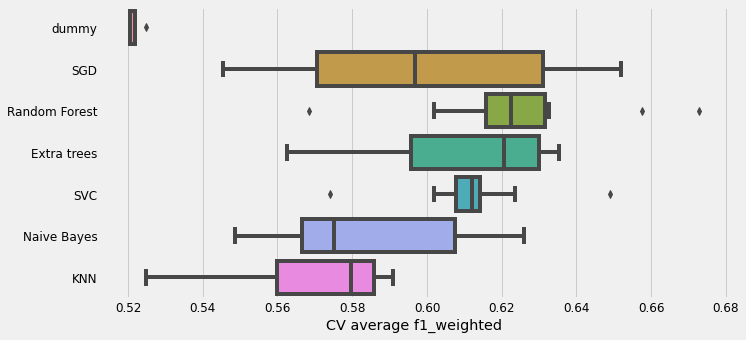

In [38]:
# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12

df_res = df_res.unstack().to_frame()

fig = plt.figure(figsize=(10,5))
sns.boxplot(
    y=df_res.index.get_level_values(0),
    x=df_res[0])
plt.xlabel(f"CV average {SCORING}")

I see a slight improvement in the f1_weighted score with SMOTE compared to no SMOTE

## Hyperparameters tuning using RandomizedSearchCV (SMOTE)
- I will select RandomForestClassifer as the model to optimize
- I will tune parameters for the processing transformers also (e.g., SelectModel)

In [39]:
# Define the CV iterator
skf = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = RANDOM_STATE
)
skf.get_n_splits()

5

In [40]:
# Create pipeline
data_pipeline = imb_pipeline([
    
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in 0.75 of observations
    ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
    # === oversampling === # 
    # upsample the minority classes to have 0.25 of the majority class, so 500 for class 1-3
    ('oversampling', SMOTE(sampling_strategy={1:500, 2:500, 3:500},
                     random_state = RANDOM_STATE)),
    
    # === undersampling ==== # 
    # undersample the majority class to have 2x of minority class, so 1000 for class 4
    ('undersampling', RandomUnderSampler(sampling_strategy={4:1000},
                                         random_state=RANDOM_STATE)),  
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf, threshold="1.25*median")),
    
    # === model === #
    ('clf',  RandomForestClassifier(random_state= RANDOM_STATE))
     
])

In [41]:
# random grid
random_grid = {
    
    # drop_nzv parameterse
    "drop_nzv__tol":[0.75, 0.8, 0.9],
    
    # feature selection parameters
    "fs__threshold":["median","1.25*median", "1.5*median"],
    
    # classifier parameters 
    "clf__n_estimators": [10, 100, 1000],
    "clf__max_depth": [None,1,3,10,40,50],
    "clf__min_samples_split": [2,5,10,50,100],
    "clf__min_samples_leaf": [2,5,10,50,100]
}

In [42]:
# Perform random search of the parameters, using a 5 fold CV to estimate the test metric for each setting.

# init random grid search object
rand_grid_search = RandomizedSearchCV(estimator = data_pipeline,
                                param_distributions = random_grid,
                                n_iter = 10,  # randomly select 10 different settings to try
                                cv = skf,       # use 5-fold CV for each setting to estimate its test metric
                                scoring=SCORING,
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM_STATE)

In [43]:
# fit model
rand_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   estimator=Pipeline(steps=[('missing_imputation',
                                              MeanMedianImputer()),
                                             ('drop_nzv',
                                              DropConstantFeatures(tol=0.75)),
                                             ('oversampling',
                                              SMOTE(random_state=10,
                                                    sampling_strategy={1: 500,
                                                                       2: 500,
                                                                       3: 500})),
                                             ('undersampling',
                                              RandomUnderSampler(random_state=10,
                                                                 sampling_strategy={4: 1000}))...
                               

In [44]:
print(f"The mean CV {SCORING} of the best estimator is: {rand_grid_search.best_score_}")

The mean CV f1_weighted of the best estimator is: 0.631441202444359


In [45]:
# Optimized parameters
rand_grid_search.best_params_ 

{'fs__threshold': 'median',
 'drop_nzv__tol': 0.8,
 'clf__n_estimators': 100,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 2,
 'clf__max_depth': 50}

## Hyperparameters tuning using GridSearchCV (SMOTE)
- Hone in on a smaller set of hyperparameters to tune (fine tuning)

In [46]:
# Create pipeline, setting some parameters based on Random Search results
data_pipeline = imb_pipeline([
    
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in 0.75 of observations
    ('drop_nzv', DropConstantFeatures(tol=0.8)),
    
    # === oversampling === # 
    # upsample the minority classes to have 0.25 of the majority class, so 500 for class 1-3
    ('oversampling', SMOTE(sampling_strategy={1:500, 2:500, 3:500},
                     random_state = RANDOM_STATE)),
    
    # === undersampling ==== # 
    # undersample the majority class to have 2x of minority class, so 1000 for class 4
    ('undersampling', RandomUnderSampler(sampling_strategy={4:1000},
                                         random_state=RANDOM_STATE)),  
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf, threshold="1.25*median")),
    
    # === model === #
    ('clf',  RandomForestClassifier(n_estimators = 100, random_state= RANDOM_STATE))
     
])

In [47]:
# parameter grid
param_grid = {
     
    # feature selection parameters
    "fs__threshold":["0.5*median","0.75*median","median"],
    
    # classifier parameters 
    "clf__max_depth": [40, 50, 60],
    "clf__min_samples_split": [8,10,15],
    "clf__min_samples_leaf": [1,2,3]
}

In [48]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = data_pipeline, 
                           param_grid = param_grid, 
                           cv = skf, 
                           scoring=SCORING,
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [49]:
# fit model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('missing_imputation',
                                        MeanMedianImputer()),
                                       ('drop_nzv',
                                        DropConstantFeatures(tol=0.8)),
                                       ('oversampling',
                                        SMOTE(random_state=10,
                                              sampling_strategy={1: 500, 2: 500,
                                                                 3: 500})),
                                       ('undersampling',
                                        RandomUnderSampler(random_state=10,
                                                           sampling_strategy={4: 1000})),
                                       ('scal...
                                        SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                        

In [50]:
# Let's take a look at the optimal parameters
grid_search.best_params_

{'clf__max_depth': 40,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 10,
 'fs__threshold': '0.5*median'}

In [51]:
# What is the score of the model with the optimal parameter
print(f"The optimal model has {SCORING} of {grid_search.best_score_}")

The optimal model has f1_weighted of 0.6369478720545895


In [52]:
# Persist the optimal pipeline (NOTE: the estimator of the grid_search object is a pipeline)
grid_search_best_pipeline_smote = grid_search.best_estimator_

# Save as pickle
with open(Path('models','mclass_smote_grid_search_best_pipeline.pkl'), 'wb') as f:
    pickle.dump(grid_search_best_pipeline_smote, f)

## Selected features

In [53]:
# Original number of columns in X_train
len(train_feature_names)

219

In [54]:
# features dropped due to nzv
dropped_features = grid_search_best_pipeline_smote.named_steps.drop_nzv.features_to_drop_
len(dropped_features)

117

In [55]:
# features that remain after dropping those with nzv
feature_names_post_nzv= [f for f in X_train.columns.values if f not in dropped_features]
len(feature_names_post_nzv)

102

In [56]:
# Get the boolean mask of features that are selected by SelectFrom Model
mask = (grid_search_best_pipeline_smote.named_steps.fs.get_support())
len(mask)

102

In [57]:
# Get list of features that are selected
selected_features=list(compress(feature_names_post_nzv, mask))
len(selected_features)

98

## Feature importance from Random Forest (SMOTE)

In [58]:
# Get best random forest model
best_rf= grid_search_best_pipeline_smote.named_steps["clf"]

In [59]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': selected_features, 
                                'importance': best_rf.feature_importances_})
feature_results.head()

,feature,importance
0,paredblolad,0.010345
1,pisocemento,0.003735
2,pisomoscer,0.007912
3,cielorazo,0.014274
4,sanitario2,0.002162


<AxesSubplot:title={'center':'Top 10 important features from random forest'}, xlabel='Features', ylabel='Normalized feature importance'>

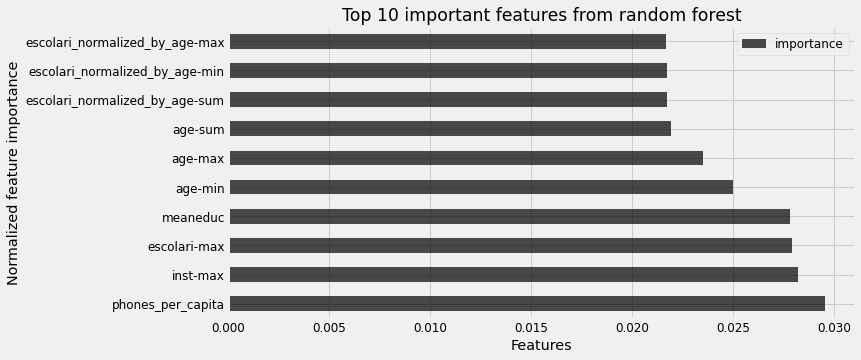

In [60]:
# Bar plot

# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

(feature_results
     .sort_values("importance", ascending=False)
     .set_index("feature")
     .head(10)
     .plot.barh(
         ax=ax,
         color='k',
         alpha=0.7,
         title="Top 10 important features from random forest",
         ylabel="Normalized feature importance",
         xlabel="Features"         
     ))

## Using Cost-Sensitive Learning for Multi-class classification
- Instead of changing the distribution of classes of the train set, let's instead try to put different weights on the error that the cost function of the statistical learning algorithm seeks to minimizes.
- Not all error are the same. The error that involves minority classes are more "serious" than that of the majority class.
- Set class_weight='balanced' for RandomForestClassifier. I will place more weight on the minority classes and less on the majority class

### Hyperparameters tuning using RandomizedSearchCV (Cost-Sensitive Learning)

In [61]:
# Create pipeline
data_pipeline = imb_pipeline([
    
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in 0.75 of observations
    ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf, threshold="1.25*median")),
    
    # === model === #
    ('clf',  RandomForestClassifier(random_state= RANDOM_STATE,
                                    class_weight='balanced'))
     
])

In [62]:
# random grid
random_grid = {
    
    # drop_nzv parameterse
    "drop_nzv__tol":[0.75, 0.8, 0.9],
    
    # feature selection parameters
    "fs__threshold":["median","1.25*median", "1.5*median"],
    
    # classifier parameters 
    "clf__n_estimators": [10, 100, 1000],
    "clf__max_depth": [None,1,3,10,40,50],
    "clf__min_samples_split": [2,5,10,50,100],
    "clf__min_samples_leaf": [2,5,10,50,100]
}

# Perform random search of the parameters, using a 5 fold CV to estimate the test metric for each setting.

# init random grid search object
rand_grid_search = RandomizedSearchCV(estimator = data_pipeline,
                                param_distributions = random_grid,
                                n_iter = 10,  # randomly select 10 different settings to try
                                cv = skf,       # use 5-fold CV for each setting to estimate its test metric
                                scoring=SCORING,
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM_STATE)

# fit model
rand_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   estimator=Pipeline(steps=[('missing_imputation',
                                              MeanMedianImputer()),
                                             ('drop_nzv',
                                              DropConstantFeatures(tol=0.75)),
                                             ('scaler', MinMaxScaler()),
                                             ('fs',
                                              SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                                                                                             random_state=10),
                                                              threshold='1.25*median')),
                                             ('clf',
                                              RandomForestC...t='balanced',
                                                                     random_state

In [63]:
print(f"The mean CV {SCORING} of the best estimator is: {rand_grid_search.best_score_}")

The mean CV f1_weighted of the best estimator is: 0.6264864598954242


In [64]:
# Optimized parameters
rand_grid_search.best_params_ 

{'fs__threshold': 'median',
 'drop_nzv__tol': 0.8,
 'clf__n_estimators': 100,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 2,
 'clf__max_depth': 50}

### Hyperparameters tuning using GridSearchCV (Cost-Sensitive Learning)
- Hone in on a smaller set of hyperparameters to tune (fine tuning)

In [65]:
# Create pipeline, setting some parameters based on Random Search results
data_pipeline = imb_pipeline([
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in tol of observations
    ('drop_nzv', DropConstantFeatures(tol=0.8)),
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf)),
    
    # === model === #
    ('clf',  RandomForestClassifier(n_estimators=100, 
                                    class_weight = 'balanced',
                                    random_state=RANDOM_STATE))
 ])

In [66]:
# parameter grid
param_grid = {
     
    # feature selection parameters
    "fs__threshold":["0.5*median","0.75*median","median"],
    
    # classifier parameters 
    "clf__max_depth": [40, 50, 60],
    "clf__min_samples_split": [8,10,15],
    "clf__min_samples_leaf": [1,2,3]
}

In [67]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = data_pipeline, 
                           param_grid = param_grid, 
                           cv = skf, 
                           scoring=SCORING,
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [68]:
# fit model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('missing_imputation',
                                        MeanMedianImputer()),
                                       ('drop_nzv',
                                        DropConstantFeatures(tol=0.8)),
                                       ('scaler', MinMaxScaler()),
                                       ('fs',
                                        SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                                                                                       random_state=10))),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [40, 50, 60],
                         'clf__min_samples_leaf': [1

In [69]:
# Let's take a look at the optimal parameters
grid_search.best_params_

{'clf__max_depth': 40,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 15,
 'fs__threshold': '0.5*median'}

In [70]:
# What is the score of the model with the optimal parameter
print(f"The optimal model has {SCORING} of {grid_search.best_score_}")

The optimal model has f1_weighted of 0.6348928939809688


In [71]:
# Persist the optimal pipeline (NOTE: the estimator of the grid_search object is a pipeline)
grid_search_best_pipeline_csl = grid_search.best_estimator_

# Save as pickle
with open(Path('models','mclass_csl_grid_search_best_pipeline.pkl'), 'wb') as f:
    pickle.dump(grid_search_best_pipeline_csl, f)

### Selected features

In [72]:
# Original number of columns in X_train
len(train_feature_names)

219

In [73]:
# features dropped due to nzv
dropped_features = grid_search_best_pipeline_csl.named_steps.drop_nzv.features_to_drop_
len(dropped_features)

117

In [74]:
# Get the boolean mask of features that are selected by SelectFrom Model
mask = (grid_search_best_pipeline_csl.named_steps.fs.get_support())
len(mask)

102

In [75]:
# Get list of features that are selected
selected_features=list(compress(feature_names_post_nzv, mask))
len(selected_features)

98

### Feature importance from Random Forest

In [76]:
# Get best random forest model
best_rf= grid_search_best_pipeline_csl.named_steps["clf"]

In [77]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': selected_features, 
                                'importance': best_rf.feature_importances_})
feature_results.head()

,feature,importance
0,paredblolad,0.006326
1,pisocemento,0.004174
2,pisomoscer,0.005548
3,cielorazo,0.006111
4,sanitario2,0.002364


<AxesSubplot:title={'center':'Top 10 important features from random forest'}, xlabel='Features', ylabel='Normalized feature importance'>

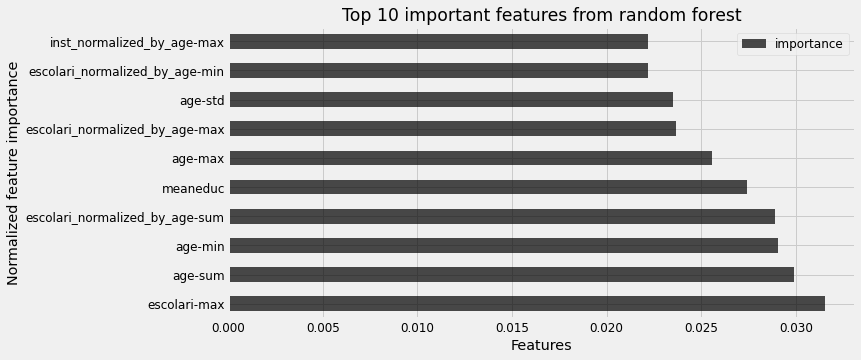

In [78]:
# Bar plot

# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

(feature_results
     .sort_values("importance", ascending=False)
     .set_index("feature")
     .head(10)
     .plot.barh(
         ax=ax,
         color='k',
         alpha=0.7,
         title="Top 10 important features from random forest",
         ylabel="Normalized feature importance",
         xlabel="Features"         
     ))

### Confusion Matrix (Cost-Sensitive Learning)
Method 1:
- Create train and validation set
- Train model on the train set
- Test model with the validation set: assess with the confusion matrix

Method 2:
- Use the FULL train set (don't split it into train and validation set)
- Performs K-fold CV (e.g., split FULL train set into 10 folds). Use 1 fold to test, and the remaining folds to train.
- If I use corss_val_predict(), each "test" fold is used generate "clean predictions". Meaning that the predictions were generated from a model that never saw the test data during training.
- I repeat this for all test folds to get a set clean predictions (has the same sample size as the FULL train set).

We will use Method 2

In [79]:
grid_search_best_pipeline_csl # optimal pipeline

Pipeline(steps=[('missing_imputation', MeanMedianImputer()),
                ('drop_nzv', DropConstantFeatures(tol=0.8)),
                ('scaler', MinMaxScaler()),
                ('fs',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                                                                random_state=10),
                                 threshold='0.5*median')),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=40,
                                        min_samples_leaf=3,
                                        min_samples_split=15,
                                        random_state=10))])

In [80]:
y_train_pred = cross_val_predict(
    estimator = grid_search_best_pipeline_csl, # an estimator could be a pipeline or model
    X = X_train,
    y = y_train,
    cv = skf
)

In [81]:
# I have a set of clean predictions in y_train_pred
y_train_pred.shape, y_train.shape 

((2973,), (2973,))

In [82]:
# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[  79,   75,   25,   43],
       [  63,  185,   82,  112],
       [  34,  122,   72,  127],
       [  63,  207,  166, 1518]])

**Plot the confusion in a heatmap**

In [83]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[  79   75   25   43]
 [  63  185   82  112]
 [  34  122   72  127]
 [  63  207  166 1518]]


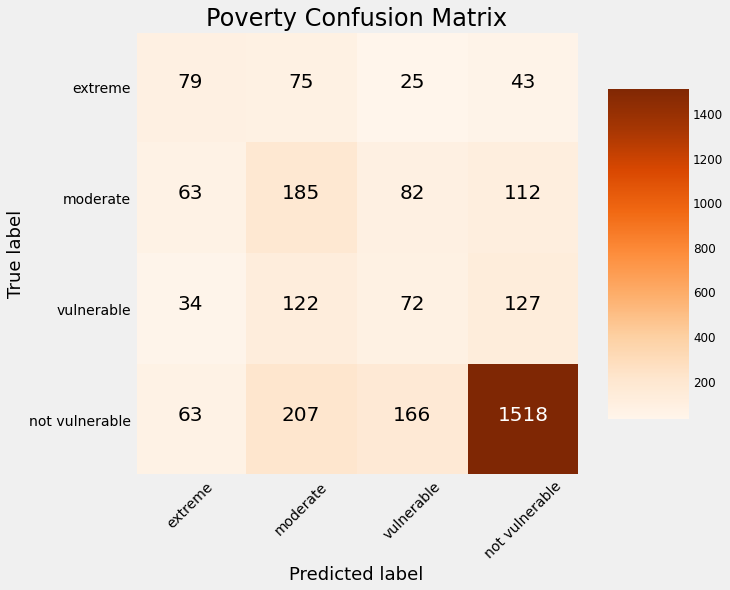

In [84]:
plot_confusion_matrix(cm = cm, 
                      classes = ['extreme', 'moderate', 'vulnerable', 'not vulnerable'],
                      normalize=False,
                      title = 'Poverty Confusion Matrix')

Normalized confusion matrix
[[0.35585586 0.33783784 0.11261261 0.19369369]
 [0.14253394 0.41855204 0.18552036 0.25339367]
 [0.09577465 0.34366197 0.2028169  0.35774648]
 [0.03224156 0.10593654 0.08495394 0.77686796]]


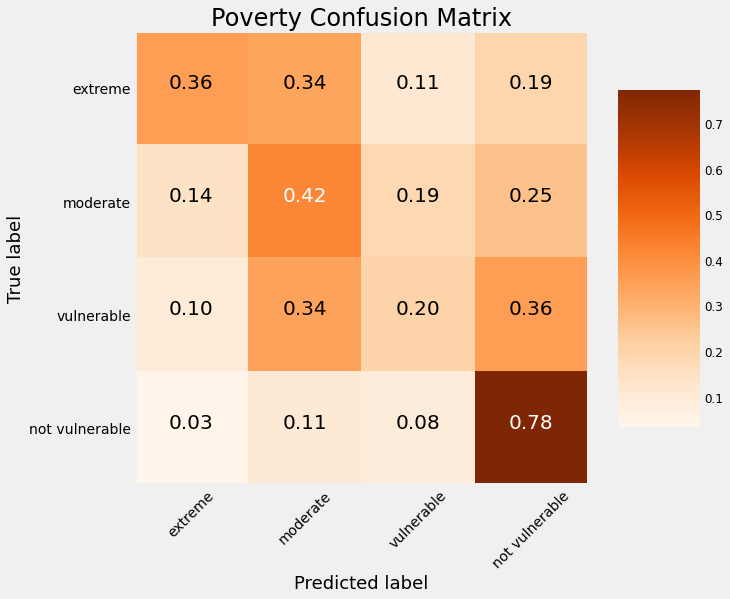

In [85]:
plot_confusion_matrix(cm = cm, 
                      classes = ['extreme', 'moderate', 'vulnerable', 'not vulnerable'],
                      normalize=True,
                      title = 'Poverty Confusion Matrix')

### Comments:
- Slightly better performance on minority class compared to no SMOTE/cost sensitive learning

- Since we are more interested in how well the model predicts extreme poverty, we will look at the positive (and minority) class: 
    - The model only correctly predicts 0.36 of all observations that actually have extreme poverty. The model has 36% recall for the extreme poverty class.
    - The model makes 239 predictions that are extreme poverty. Of those, 67 are correct. The model therefore has 79/239 = 0.33 precision.

### ROC curve
- REF: https://stackoverflow.com/questions/50941223/plotting-roc-curve-with-multiple-classes
- I use the optimized pipeline to compute the proba for each fold (y_scores)
- I use these proba scores to compute the fpr and tpr for each possible threshold.
- The results will be used to create ROC curve

#### A NOTE about the ROC_AUC score for multiclass classification
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
- `roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)`
- If `average` is set to `None` then the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Note: multiclass ROC AUC currently only handles the ‘macro’ and ‘weighted’ averages. 
- `average` will be ignored if outcome is binary

In [86]:
y_train_pred_scores = cross_val_predict(
    estimator = grid_search_best_pipeline_csl, # an estimator could be a pipeline or model
    X = X_train,
    y = y_train,
    cv = skf,
    method = "predict_proba"
)

In [87]:
y_train_pred_scores.shape # I have 4 sets of scores, one for each class

(2973, 4)

In [88]:
y_train_pred_scores

array([[0.11977334, 0.09938543, 0.08863526, 0.69220598],
       [0.09462191, 0.10945562, 0.09931735, 0.69660512],
       [0.18159628, 0.26688649, 0.22684055, 0.32467668],
       ...,
       [0.28794   , 0.32905261, 0.22716969, 0.1558377 ],
       [0.15288589, 0.22687693, 0.3466442 , 0.27359299],
       [0.11655596, 0.28677098, 0.34614291, 0.25053014]])

**Plotting the ROC curve**

In [89]:
y_train_pred_scores[:,1] # proba of the first class

array([0.09938543, 0.10945562, 0.26688649, ..., 0.32905261, 0.22687693,
       0.28677098])

In [90]:
y_train # Need to create dummy variables for each class, we will do it inside plot_multiclass_roc() function

0       4.0
1       4.0
2       4.0
3       4.0
4       4.0
       ... 
2968    1.0
2969    2.0
2970    4.0
2971    2.0
2972    2.0
Name: Target, Length: 2973, dtype: float64

In [91]:
# Map index (for 0-based array) to class label
index_level_mapping =  OrderedDict({0: 'extreme', 
                               1: 'moderate',
                               2: 'vulnerable',
                               3: 'not vulnerable'})

In [92]:
def plot_multiclass_roc(y_val, y_scores, mapping, figsize=(20, 8)):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # get dummy variables for y_val, one for each level
    y_val_dummies = pd.get_dummies(y_val, drop_first=False).values
    
    # Compute fpr and tpr for each class
    # Also compute the ROC_AUC for each class
    for k,v in mapping.items():
        fpr[v], tpr[v], _ = roc_curve(y_val_dummies[:, k], y_scores[:, k])
        roc_auc[v] = roc_auc_score(y_val_dummies[:, k], y_scores[:, k])

    # plot roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    
    for k,v in mapping.items():
        ax.plot(fpr[v], tpr[v], label=f"ROC curve for class {v} (area = {round(roc_auc[v],2)})")
    
    # plot settings
    ax.plot([0, 1], [0, 1], 'k--') # plot the 45 deg line
    
    ax.set_xlim([0.0, 1.0]) # set x and y limits
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('False Positive Rate') # set x and y labels and title
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROCs')
    
    ax.legend(loc="best")
    plt.show()

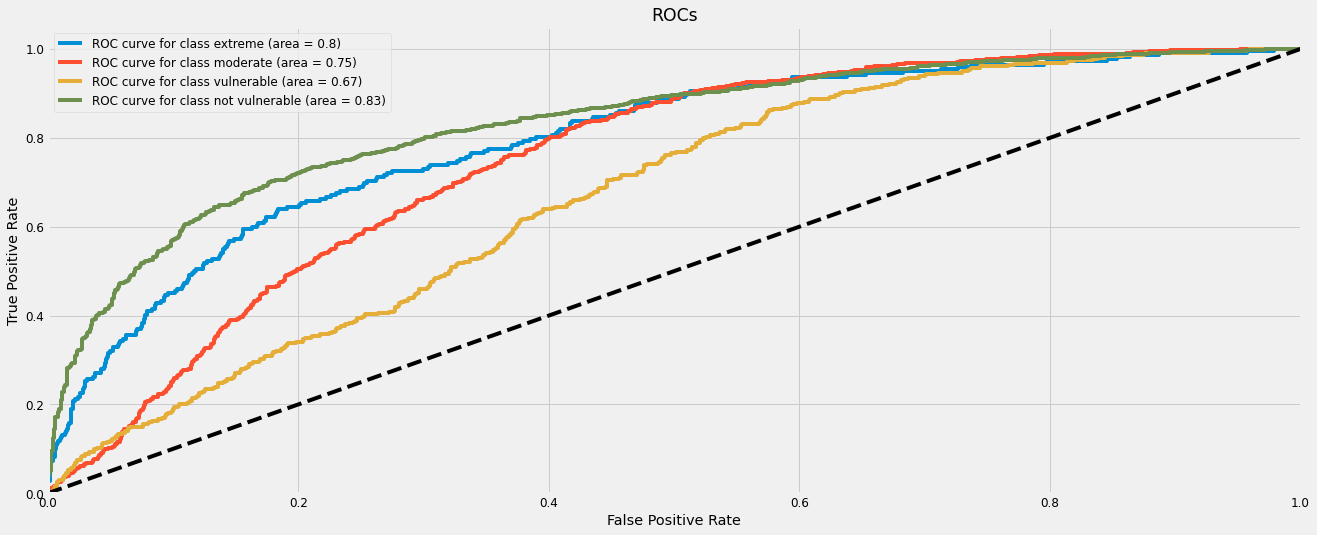

In [93]:
# Since my predictions are "clean" using cross_val_predict()
# I can use train set as my validation set  
plot_multiclass_roc(y_val = y_train,  
               y_scores = y_train_pred_scores,
               mapping = index_level_mapping)

NOTE: since our dataset has imbalanced class, ROC_AUC score tends to be an overestimation of the model performance.

### Precision and Recall curve
- As a rule of thumb, you should use AUPRC whenever the positive class is rare (as in our case) or when you care more about the false positives than the false negatives. Otherwise, we use AUROC.
- If I set my threshold to a high value, say 0.8, the classifier will make less positive predictions. In this case, its precision will increase, but its recall will decrease. The inverse is true if the threshold is low (e.g., 0.3).

#### A NOTE about the average_precision score for multiclass classification
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
- `sklearn.metrics.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)`
- If `average` is set to `None` then the scores for each class are returned. Otherwise, this argument determines the type of averaging performed on the data: "micro", "macro", "weighted", "sample"
- `average` will be ignored if outcome is binary

In [94]:
def plot_multiclass_prc(y_val, y_scores, mapping, figsize=(15, 8)):
    
    # structures
    precisions = dict()
    recalls = dict()
    thresholds = dict()
    auprcs = dict()
    
    # get dummy variables for y_val, one for each level
    y_val_dummies = pd.get_dummies(y_val, drop_first=False).values
    
    # Compute precision, recall for each class
    # Also compute the AUPRC for each class
    for k,v in mapping.items():
        precisions[v], recalls[v], _ = precision_recall_curve(y_val_dummies[:, k], y_scores[:, k])
        auprcs[v] = average_precision_score(y_val_dummies[:, k], y_scores[:, k])
    
    
    # plot precision and recall vs threshold for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    
    for k,v in mapping.items():
        ax.plot(recalls[v], precisions[v], label=f"PRCfor class {v} (area = {round(auprcs[v],2)})")
    
    # Plot settings
    ax.set_xlim([0.0, 1.0]) # set x and y limits
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('Recall') # set x and y labels and title
    ax.set_ylabel('Precision')
    ax.set_title('Precision and Recall Curves')
    
    ax.legend(loc="best")
    plt.show()

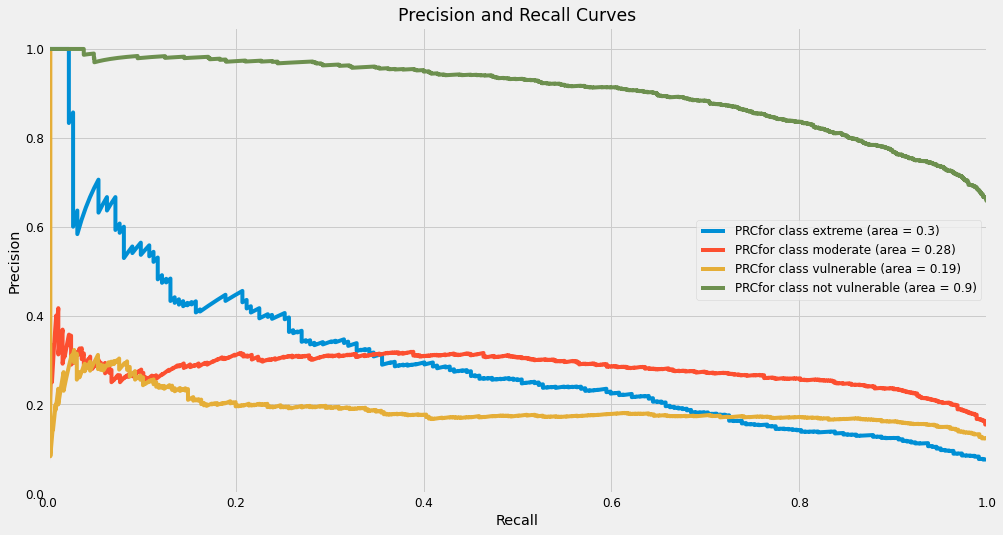

In [95]:
plot_multiclass_prc(y_val = y_train, 
                    y_scores = y_train_pred_scores, 
                    mapping = index_level_mapping)

**NOTE about precision recall curve (AUPRC)**
- Recall that if AUROC = 0.5, that means the performance of the classifier is no better than random guessing.
- The same is NOT true for AUPRC. The baseline value (lowest) for AUPRC is the proportion of positive outcomes in the sample:
    - positive outcomes/total # of samples
    - For us, it is:
        - 0.07 for extreme
        - 0.14 for moderate
        - 0.11 for vulnerable
        - 0.65 for not vulnerable

In [96]:
y_train.value_counts(normalize=True)

4.0    0.657249
2.0    0.148671
3.0    0.119408
1.0    0.074672
Name: Target, dtype: float64

### Learning Curves
- Purpose: check if my model is overfitting or underfitting the data.
- Estimate the train and test metric of the model using k-fold CV. The model will be trained on data with varying sizes (starting at n=1, n=2, ...) 
- NOTE: the train metric is computed by training the model with the train set (remaining folds), and assessing using the same train set.
- At each iteration, I get different CV scores.
- Plot the CV scores against sample size to get learning curves.
- If the train metric is a lot higher than the test metric, then I am overfitting.
- If both the train metric and test metric are low, then I am underfitting.

In [97]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator = grid_search_best_pipeline_csl, 
    X = X_train, 
    y = y_train,
    cv = skf,
    scoring = SCORING, # need to use f1_weighted or f1_macro since I have multiclass
    train_sizes=[0.01,0.2,0.4,0.6,0.8,1.0]) # in proportion

In [98]:
train_sizes

array([  23,  475,  951, 1426, 1902, 2378])

In [99]:
train_scores.shape # 5 folds, 6 training sets with varying sizes

(6, 5)

In [100]:
valid_scores.shape

(6, 5)

In [101]:
def plot_learning_curve(train_scores, valid_scores, train_sizes):
    plt.figure(figsize = (10, 8))
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    

    plt.plot(train_sizes, train_scores.mean(axis=1), "r-", label="train")
    plt.plot(train_sizes, valid_scores.mean(axis=1), "b--", label="val")
    
    plt.xlabel("Training set size")
    plt.ylabel(f"{SCORING}")
    plt.title("Learning Curves")
    plt.legend(loc="best")

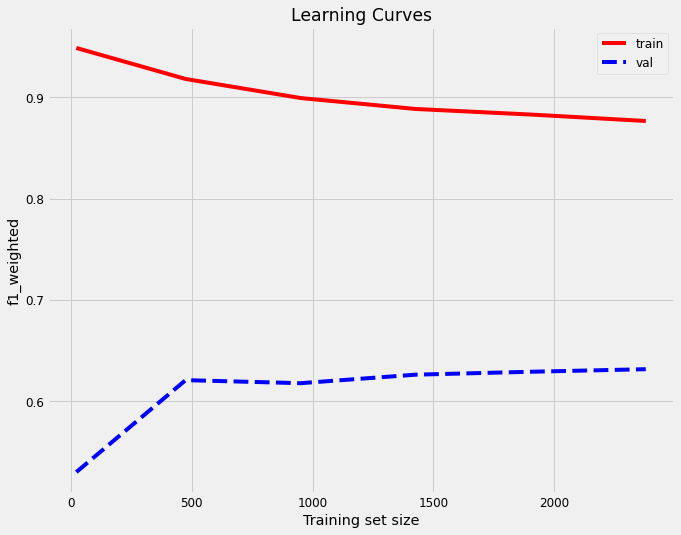

In [102]:
plot_learning_curve(train_scores, valid_scores, train_sizes)

**Comments** 
- My model is overfitting as the validation f1 score is 0.3 to 0.4 lower than the train f1 score
- I need to:
    - increase sample size
    - reduce model complexity
    - Use k-fold CV to estimate the test error/metric